<a href="https://colab.research.google.com/github/Raanank10/Instagram-s-influencers/blob/raanan_20_09/Instagram_influencers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instagram_influencers**

# Global Parameters

In [69]:
path = 'https://raw.githubusercontent.com/Raanank10/Instagram-s-influencers/main/ai_posts_analysis_data.xlsx'
fname = 'ai_posts_analysis_data.xlsx'
# fname = 'https://github.com/Raanank10/Instagram-s-influencers/blob/ai_posts_analysis_data.xlsx'
# fname = 'https://github.com/Raanank10/Instagram-s-influencers/blob/main/ai_posts_analysis_data.xlsx'


train_size = 0.75
rand_state = 990

# Get the Data

In [70]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd
import missingno as msno

# SK Learn
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score , confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report # elad 20210708
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.preprocessing import OrdinalEncoder # elad 20210911

# Trees Visualization
import pydot
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO

# Misc
import warnings
from sys import modules
from time import time
from platform import python_version

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# IPython
from IPython.display import Image, display

# Confuguration
warnings.filterwarnings('ignore')
%matplotlib inline

In [71]:
df = pd.read_csv(path, index_col=0)  
df.head()

,USERID,USERNAME,FULLNAME,FOLLOWER,POST ID,SHORTCODE,LIKES,COMMENTS,ENGAGEMENT,URL,ACCESSIBILITY CAPTION,CAPTION,LOCATION,CITY,COUNTRY,TIME,IMAGE LABELS,CAPTION INTEREST,ACCESSIBILITY CAPTION INTEREST,IMAGE LABEL INTEREST,IMAGE URL,COMMENT DISABLED,IS VIDEO,HAS AUDIO,VIDEO URL,VIDEO VIEW COUNT
1,,,,,,,,,,,,,,,,,,,,,,,,,,
1918,36193140327,elastici_e_passamaneria,Elastici e Passamaneria,1052,2530600951335029174,CMegChUlwm2,23,0,2.19,https://www.instagram.com/p/CMegChUlwm2,"Photo by Elastici e Passamaneria on March 16, 2021.",FFP2 MADE IN ITALY????????#ffp2mask#italianstyle#madeinitaly????????#produzionepropria#produttori#farmacie#farmacieitaliane#parafarmacia#mascherinelavabili#mask#ffp2,NaN,NaN,NaN,1615891163,"Clothing, Apparel, Text, Money, Collage, Advertisement, Poster",education,movies,business,https://instagram.fdok2-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/c0.180.1440.1440a/s640x640/160374486_2823675294516254_158720847037227315_n.jpg?tp=1&_nc_ht=instagram.fdok2-1.fna.fbcdn.net&_nc_cat=102&_nc_ohc=fXOFeWEt3dcAX9moTcA&edm=ABfd0MgBAAAA&ccb=7-4&oh=cc36e9f840bc93314fcc9e76c9e4b8c6&oe=60DA4B27&_nc_sid=7bff83,no,no,no,NaN,NaN
1919,8210198494,pamela.latorre.73,Pamela La Torre,309,2595285287724490476,CQETjgBnZ7s,55,23,25.24,https://www.instagram.com/p/CQETjgBnZ7s,"Photo by Pamela La Torre on June 13, 2021. May be an image of one or more people, people standing and indoor.",Prima comunione Giorgio,Santissimo Crocifisso,"Taranto, Italy",NaN,1623602137,"Person, Human, Photographer, Photography, Photo, Furniture, Shoe, Clothing, Footwear, Apparel, Interior Design, Indoors",news,arts_entertainment,style_fashion,https://instagram.fhel3-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/s640x640/131454075_203114518334788_1962979990399529842_n.jpg?tp=1&_nc_ht=instagram.fhel3-1.fna.fbcdn.net&_nc_cat=104&_nc_ohc=XmsE8bbC2cIAX-0rYFU&edm=ABfd0MgBAAAA&ccb=7-4&oh=4ca96de8a58eafc0ac1e2eea47d28236&oe=60D9DF1A&_nc_sid=7bff83,no,no,no,NaN,NaN
1920,36838177086,ilaria._004,????????????????,649,2356209223949454778,CCy784yAY26,138,2,21.57,https://www.instagram.com/p/CCy784yAY26,"Photo by ???????????????? on July 18, 2020. May be an image of 1 person.",mirame????,NaN,NaN,NaN,1595102049,"Clothing, Apparel, Person, Human, Female, Swimwear, Footwear, Woman, Bikini, Shoe, Skin, Pants, Flooring, Girl",education,arts_entertainment,style_fashion,https://instagram.fgua5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/c0.86.1080.1080a/s640x640/111218478_173463267523124_4585802501296990831_n.jpg?tp=1&_nc_ht=instagram.fgua5-1.fna.fbcdn.net&_nc_cat=108&_nc_ohc=3eLtxoYSgkUAX-UqCUh&edm=ABfd0MgBAAAA&ccb=7-4&oh=8ca65c0f03f5315391059b88e4879625&oe=60DAB7D9&_nc_sid=7bff83,no,no,no,NaN,NaN
1921,33286901341,wellbishstore,Wellbish Store,188,2462740031272344745,CItaQKiH1yp,6,0,3.19,https://www.instagram.com/p/CItaQKiH1yp,"Photo by Wellbish Store on December 12, 2020. May be an image of jewelry.",How sweet is your Heart? ❤️????\n.\n.\n???? Follow @wellbishstore\n???? Turn notification on\n☑️ Tag me in your stories\n???? click the link in my bio! ????\n.\n.\n#wellbishstore #relationship #love #boyfriend #girlfriend #bracelet #key #heart #jewelry #engagement #sweethearts,NaN,NaN,NaN,1607801511,"Pendant, Accessories, Accessory, Goggles",style_fashion,arts_entertainment,style_fashion,https://instagram.fhyd2-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/s640x640/130800364_391796488911604_6608581821876444117_n.jpg?tp=1&_nc_ht=instagram.fhyd2-1.fna.fbcdn.net&_nc_cat=104&_nc_ohc=aNFdVzB8RNkAX-OmQYk&edm=ABfd0MgBAAAA&ccb=7-4&oh=d33040e44bb815f94e36b16550c6dbac&oe=60D955AB&_nc_sid=7bff83,no,no,no,NaN,NaN
1922,5633363536,amineblc,Mohamed Amine,1103,2127311663854320191,B2Fuq_ylPo_,46,4,4.53,https://www.instagram.com/p/B2Fuq_ylPo_,Photo by Mohamed Amine in Mawazine.,NaN,Mawazine,"Ksar Hellal, Tunisia",Tunisia,1567815333,"Clothing, Apparel, Person, Human, Sunglasses, Accessories, Accessory, Face, Scarf, Portrait, Photography, Photo, Glasses, People, Selfie, Female, Coat, Smile",NaN,news,style_fashion,https://ins

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4792 entries, 1918 to 6709
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   USERID                          4792 non-null   int64  
 1   USERNAME                        4792 non-null   object 
 2   FULLNAME                        4666 non-null   object 
 3   FOLLOWER                        4792 non-null   int64  
 4   POST ID                         4792 non-null   int64  
 5   SHORTCODE                       4792 non-null   object 
 6   LIKES                           4792 non-null   int64  
 7   COMMENTS                        4792 non-null   int64  
 8   ENGAGEMENT                      4792 non-null   float64
 9   URL                             4792 non-null   object 
 10  ACCESSIBILITY CAPTION           3943 non-null   object 
 11  CAPTION                         4310 non-null   object 
 12  LOCATION                       

# EDA

Column names: Replace white spaces with underscore 

In [73]:
df.columns = df.columns.str.replace(' ', '_')

Check for each column how many unique is there (lenght of the dataset 4792, len(df)) 

In [74]:
df.apply(lambda col: len(col.unique())).sort_values(ascending=False)

POST_ID                           4792
SHORTCODE                         4792
IMAGE_URL                         4792
URL                               4792
TIME                              4791
IMAGE_LABELS                      4666
CAPTION                           4216
ACCESSIBILITY_CAPTION             3658
ENGAGEMENT                        1415
VIDEO_URL                          809
LIKES                              588
LOCATION                           533
VIDEO_VIEW_COUNT                   472
USERNAME                           447
USERID                             447
FULLNAME                           432
FOLLOWER                           418
CITY                               328
COMMENTS                           138
COUNTRY                             44
CAPTION_INTEREST                    36
IMAGE_LABEL_INTEREST                35
ACCESSIBILITY_CAPTION_INTEREST      27
COMMENT_DISABLED                     2
IS_VIDEO                             2
HAS_AUDIO                

## Data Cleaning

In [75]:
# Descriptive statistics for each column
df.describe()

,USERID,FOLLOWER,POST_ID,LIKES,COMMENTS,ENGAGEMENT,TIME,VIDEO_VIEW_COUNT
count,4.792000e+03,4792.000000,4.792000e+03,4792.000000,4792.000000,4792.000000,4.792000e+03,808.000000
mean,2.075851e+10,4737.154633,2.511704e+18,130.603923,10.970993,5.917452,1.613638e+09,3787.849010
std,1.934902e+10,24869.309437,1.817231e+17,996.768347,79.816138,11.570440,2.166305e+07,38903.901192
min,6.121430e+05,1.000000,6.216878e+17,0.000000,0.000000,0.000000,1.388331e+09,3.000000
25%,2.138415e+09,522.000000,2.541024e+18,13.000000,0.000000,1.150000,1.617134e+09,48.000000
50%,1.040845e+10,1338.000000,2.580869e+18,30.000000,2.000000,2.850000,1.621884e+09,144.500000
75%,4.430101e+10,3296.000000,2.595312e+18,77.250000,7.000000,6.782500,1.623605e+09,478.750000
max,4.836575e+10,469270.000000,2.602336e+18,47638.000000,3921.000000,352.000000,1.624443e+09,968807.000000


## Handle NaN valus

How Many NaN values are ther in the datast?

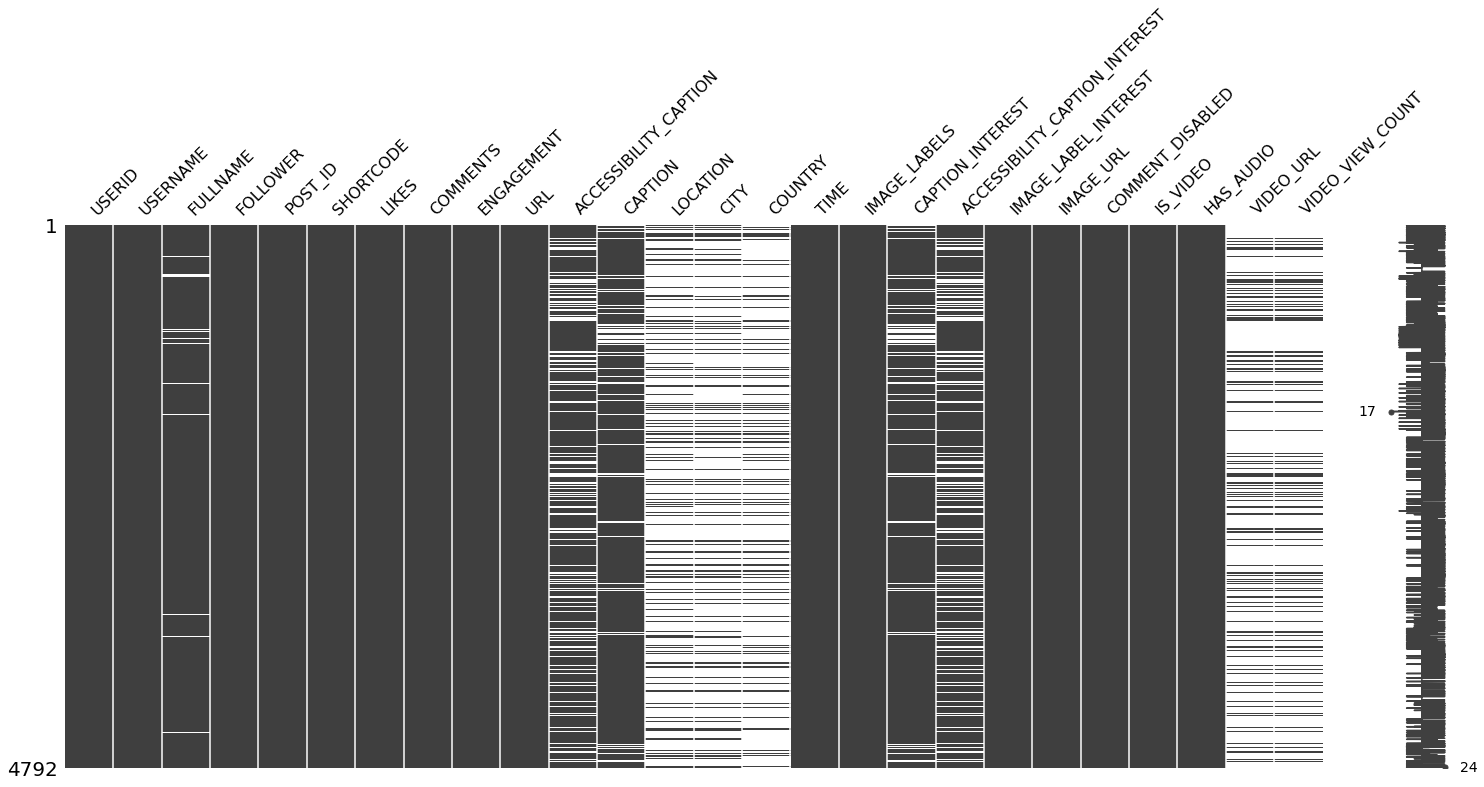

In [76]:
msno.matrix(df)

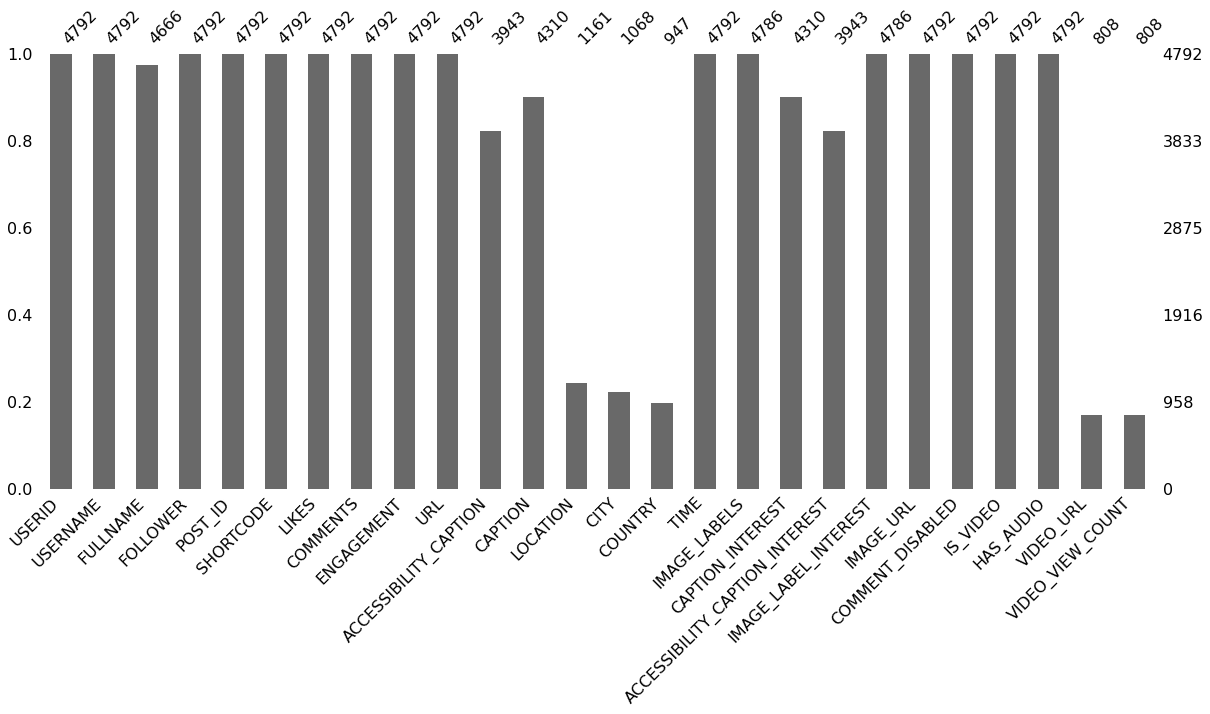

In [77]:
msno.bar(df, figsize=(20, 8))

Conert unix time to separate Date and Time columns

In [78]:
df['DATETIME'] = pd.to_datetime(df['TIME'],unit='s')

In [79]:
df['YEAR'] = pd.DatetimeIndex(df['DATETIME']).year
df['MONTH'] = pd.DatetimeIndex(df['DATETIME']).month
df['DAY'] = pd.DatetimeIndex(df['DATETIME']).day
df['DAYOFWEEK'] = pd.DatetimeIndex(df['DATETIME']).dayofweek
df['HOUR'] = pd.DatetimeIndex(df['DATETIME']).hour
df['MINUTE'] = pd.DatetimeIndex(df['DATETIME']).minute

Remove column that all values are unique:

In [80]:
for col in df.columns:
    if len(df[col].unique()) == len(df):
        print(col)
        #df.drop(col,inplace=True,axis=1)

POST_ID
SHORTCODE
URL
IMAGE_URL


In [81]:
df.head()

,USERID,USERNAME,FULLNAME,FOLLOWER,POST_ID,SHORTCODE,LIKES,COMMENTS,ENGAGEMENT,URL,ACCESSIBILITY_CAPTION,CAPTION,LOCATION,CITY,COUNTRY,TIME,IMAGE_LABELS,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST,IMAGE_LABEL_INTEREST,IMAGE_URL,COMMENT_DISABLED,IS_VIDEO,HAS_AUDIO,VIDEO_URL,VIDEO_VIEW_COUNT,DATETIME,YEAR,MONTH,DAY,DAYOFWEEK,HOUR,MINUTE
1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1918,36193140327,elastici_e_passamaneria,Elastici e Passamaneria,1052,2530600951335029174,CMegChUlwm2,23,0,2.19,https://www.instagram.com/p/CMegChUlwm2,"Photo by Elastici e Passamaneria on March 16, 2021.",FFP2 MADE IN ITALY????????#ffp2mask#italianstyle#madeinitaly????????#produzionepropria#produttori#farmacie#farmacieitaliane#parafarmacia#mascherinelavabili#mask#ffp2,NaN,NaN,NaN,1615891163,"Clothing, Apparel, Text, Money, Collage, Advertisement, Poster",education,movies,business,https://instagram.fdok2-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/c0.180.1440.1440a/s640x640/160374486_2823675294516254_158720847037227315_n.jpg?tp=1&_nc_ht=instagram.fdok2-1.fna.fbcdn.net&_nc_cat=102&_nc_ohc=fXOFeWEt3dcAX9moTcA&edm=ABfd0MgBAAAA&ccb=7-4&oh=cc36e9f840bc93314fcc9e76c9e4b8c6&oe=60DA4B27&_nc_sid=7bff83,no,no,no,NaN,NaN,2021-03-16 10:39:23,2021,3,16,1,10,39
1919,8210198494,pamela.latorre.73,Pamela La Torre,309,2595285287724490476,CQETjgBnZ7s,55,23,25.24,https://www.instagram.com/p/CQETjgBnZ7s,"Photo by Pamela La Torre on June 13, 2021. May be an image of one or more people, people standing and indoor.",Prima comunione Giorgio,Santissimo Crocifisso,"Taranto, Italy",NaN,1623602137,"Person, Human, Photographer, Photography, Photo, Furniture, Shoe, Clothing, Footwear, Apparel, Interior Design, Indoors",news,arts_entertainment,style_fashion,https://instagram.fhel3-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/s640x640/131454075_203114518334788_1962979990399529842_n.jpg?tp=1&_nc_ht=instagram.fhel3-1.fna.fbcdn.net&_nc_cat=104&_nc_ohc=XmsE8bbC2cIAX-0rYFU&edm=ABfd0MgBAAAA&ccb=7-4&oh=4ca96de8a58eafc0ac1e2eea47d28236&oe=60D9DF1A&_nc_sid=7bff83,no,no,no,NaN,NaN,2021-06-13 16:35:37,2021,6,13,6,16,35
1920,36838177086,ilaria._004,????????????????,649,2356209223949454778,CCy784yAY26,138,2,21.57,https://www.instagram.com/p/CCy784yAY26,"Photo by ???????????????? on July 18, 2020. May be an image of 1 person.",mirame????,NaN,NaN,NaN,1595102049,"Clothing, Apparel, Person, Human, Female, Swimwear, Footwear, Woman, Bikini, Shoe, Skin, Pants, Flooring, Girl",education,arts_entertainment,style_fashion,https://instagram.fgua5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/c0.86.1080.1080a/s640x640/111218478_173463267523124_4585802501296990831_n.jpg?tp=1&_nc_ht=instagram.fgua5-1.fna.fbcdn.net&_nc_cat=108&_nc_ohc=3eLtxoYSgkUAX-UqCUh&edm=ABfd0MgBAAAA&ccb=7-4&oh=8ca65c0f03f5315391059b88e4879625&oe=60DAB7D9&_nc_sid=7bff83,no,no,no,NaN,NaN,2020-07-18 19:54:09,2020,7,18,5,19,54
1921,33286901341,wellbishstore,Wellbish Store,188,2462740031272344745,CItaQKiH1yp,6,0,3.19,https://www.instagram.com/p/CItaQKiH1yp,"Photo by Wellbish Store on December 12, 2020. May be an image of jewelry.",How sweet is your Heart? ❤️????\n.\n.\n???? Follow @wellbishstore\n???? Turn notification on\n☑️ Tag me in your stories\n???? click the link in my bio! ????\n.\n.\n#wellbishstore #relationship #love #boyfriend #girlfriend #bracelet #key #heart #jewelry #engagement #sweethearts,NaN,NaN,NaN,1607801511,"Pendant, Accessories, Accessory, Goggles",style_fashion,arts_entertainment,style_fashion,https://instagram.fhyd2-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/s640x640/130800364_391796488911604_6608581821876444117_n.jpg?tp=1&_nc_ht=instagram.fhyd2-1.fna.fbcdn.net&_nc_cat=104&_nc_ohc=aNFdVzB8RNkAX-OmQYk&edm=ABfd0MgBAAAA&ccb=7-4&oh=d33040e44bb815f94e36b16550c6dbac&oe=60D955AB&_nc_sid=7bff83,no,no,no,NaN,NaN,2020-12-12 19:31:51,2020,12,12,5,19,31
1922,5633363536,amineblc,Mohamed Amine,1103,2127311663854320191,B2Fuq_ylPo_,46,4,4.53,https://www.instagram.com/p/B2Fuq_ylPo_,Photo by Mohamed Amine in Mawazine.,NaN,Mawazine,"Ksar Hellal, Tunisia",Tunisia

In [82]:
df.URL.head()
# SHORTCODE
# URL
# IMAGE_URL
# VIDEO_URL # Not working

1
1918    https://www.instagram.com/p/CMegChUlwm2
1919    https://www.instagram.com/p/CQETjgBnZ7s
1920    https://www.instagram.com/p/CCy784yAY26
1921    https://www.instagram.com/p/CItaQKiH1yp
1922    https://www.instagram.com/p/B2Fuq_ylPo_
Name: URL, dtype: object

In [83]:
df.drop('POST_ID',inplace=True,axis=1)

In [84]:
df.drop('VIDEO_URL',inplace=True,axis=1)

In [85]:
df.drop('SHORTCODE',inplace=True,axis=1)

In [86]:
# df.drop('URL',inplace=True,axis=1)

In [87]:
df.drop('IMAGE_URL',inplace=True,axis=1)

Convert columns type to characters :

In [88]:
df['COMMENT_DISABLED'].value_counts()

no     4785
yes       7
Name: COMMENT_DISABLED, dtype: int64

In [89]:
df['COMMENT_DISABLED'] = df['COMMENT_DISABLED'].map(dict(yes=1, no=0))

In [90]:
df['IS_VIDEO'] = df['IS_VIDEO'].map(dict(yes=1, no=0))

In [91]:
df['HAS_AUDIO'] = df['HAS_AUDIO'].map(dict(yes=1, no=0))

In [92]:
df[['COMMENT_DISABLED','IS_VIDEO','HAS_AUDIO']].value_counts()

COMMENT_DISABLED  IS_VIDEO  HAS_AUDIO
0                 0         0            3981
                  1         1             722
                            0              82
1                 1         1               4
                  0         0               3
dtype: int64

In [93]:
pd.unique(df[['COMMENT_DISABLED','IS_VIDEO','HAS_AUDIO']].values.ravel('K'))

array([0, 1])

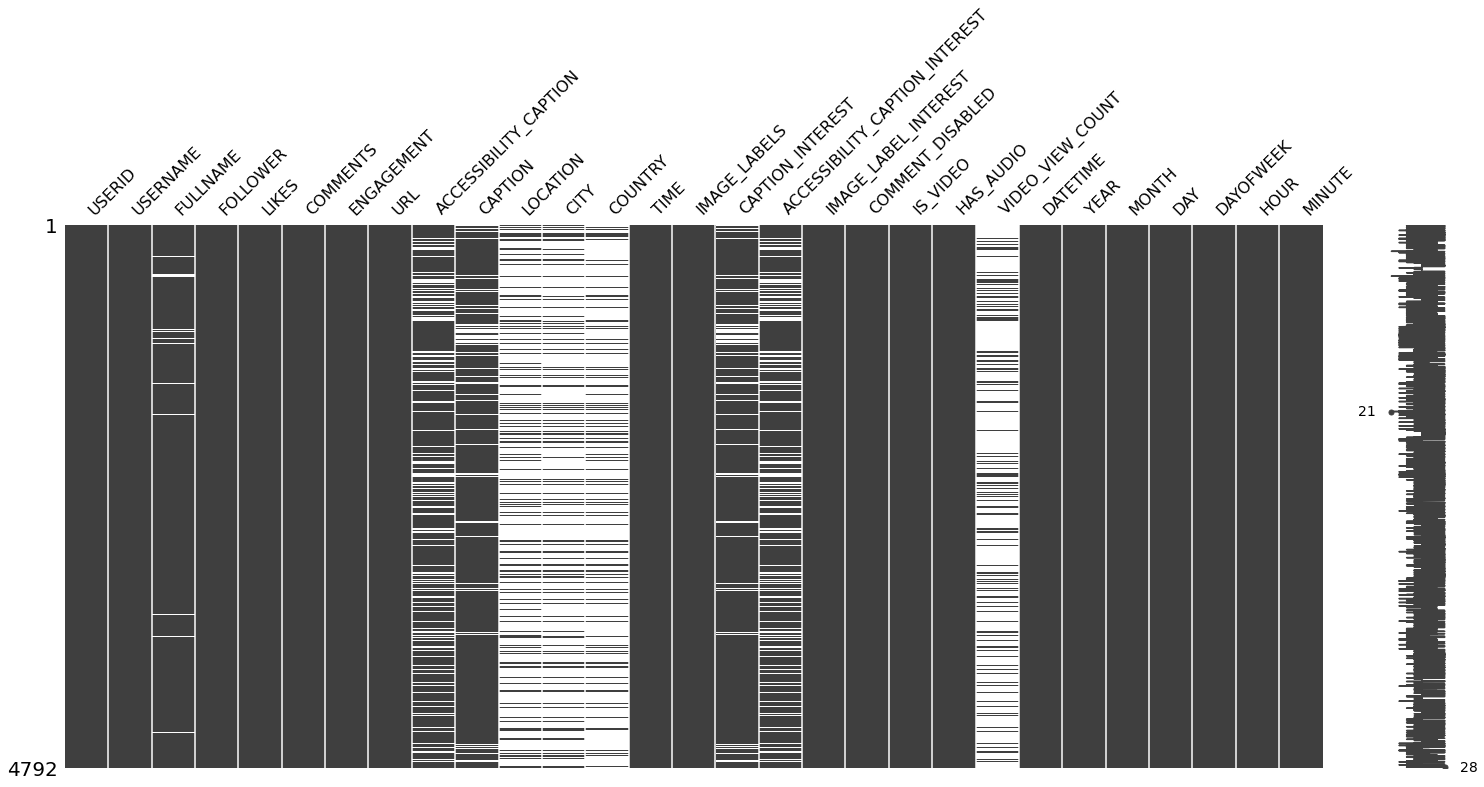

In [94]:
msno.matrix(df)

In [95]:
df.columns

Index(['USERID', 'USERNAME', 'FULLNAME', 'FOLLOWER', 'LIKES', 'COMMENTS',
       'ENGAGEMENT', 'URL', 'ACCESSIBILITY_CAPTION', 'CAPTION', 'LOCATION',
       'CITY', 'COUNTRY', 'TIME', 'IMAGE_LABELS', 'CAPTION_INTEREST',
       'ACCESSIBILITY_CAPTION_INTEREST', 'IMAGE_LABEL_INTEREST',
       'COMMENT_DISABLED', 'IS_VIDEO', 'HAS_AUDIO', 'VIDEO_VIEW_COUNT',
       'DATETIME', 'YEAR', 'MONTH', 'DAY', 'DAYOFWEEK', 'HOUR', 'MINUTE'],
      dtype='object')

Raname the index

In [96]:
df = df.rename_axis('LINE_NUM_INDEX')

Note by Eladk: we can fill location values by using a merdiction model base in the influancer and the time for the post. <BR> 
For Now, I'll just fill the columns with NULL

Replace all cases where VIDEO_VIEW_COUNT == Nan with 0. <BR> for double check i verified it with is_video column

In [97]:
df['VIDEO_VIEW_COUNT'].fillna(0, inplace=True)

Eladk note 8-Sep-2021: I still need to handle missing values in column:


*   FULLNAME
*   ACCESSIBILITY_CAPTION - specify full name, time, location, video or picture and tag
*   CAPTION - the text on this post (by the post uploader
*   LOCATION, CITY, COUNTRY - location
*   CAPTION_INTEREST -
*   ACCESSIBILITY_CAPTION_INTEREST


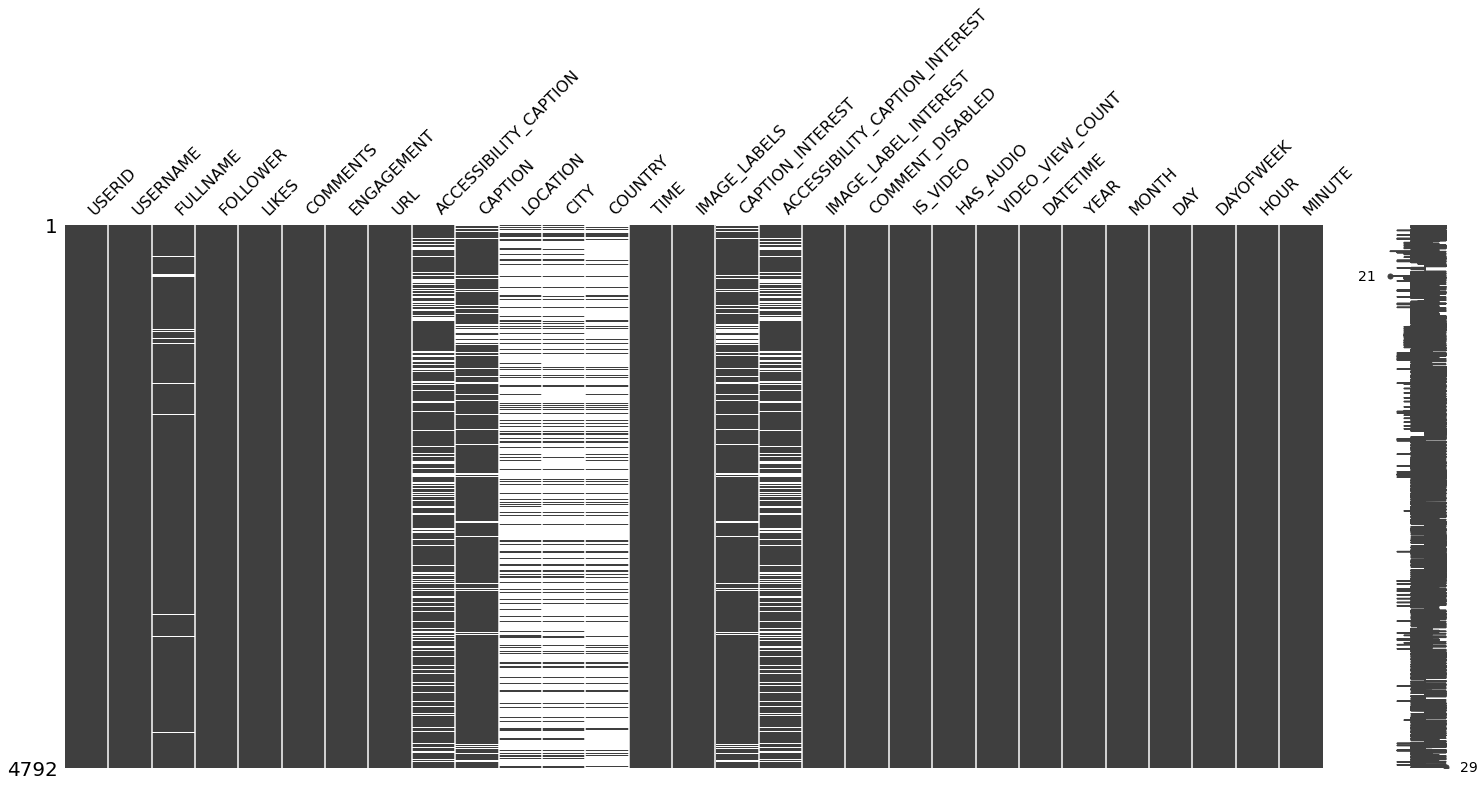

In [98]:
msno.matrix(df)

In [99]:
df.CAPTION.value_counts().sort_values(ascending=False)

????                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     23
????????                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

selecting a subset of the data:

In [100]:
df[['FULLNAME','ACCESSIBILITY_CAPTION','CAPTION','LOCATION', 'CITY', 'COUNTRY','CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']].head(5)

,FULLNAME,ACCESSIBILITY_CAPTION,CAPTION,LOCATION,CITY,COUNTRY,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST
LINE_NUM_INDEX,,,,,,,,
1918,Elastici e Passamaneria,"Photo by Elastici e Passamaneria on March 16, 2021.",FFP2 MADE IN ITALY????????#ffp2mask#italianstyle#madeinitaly????????#produzionepropria#produttori#farmacie#farmacieitaliane#parafarmacia#mascherinelavabili#mask#ffp2,NaN,NaN,NaN,education,movies
1919,Pamela La Torre,"Photo by Pamela La Torre on June 13, 2021. May be an image of one or more people, people standing and indoor.",Prima comunione Giorgio,Santissimo Crocifisso,"Taranto, Italy",NaN,news,arts_entertainment
1920,????????????????,"Photo by ???????????????? on July 18, 2020. May be an image of 1 person.",mirame????,NaN,NaN,NaN,education,arts_entertainment
1921,Wellbish Store,"Photo by Wellbish Store on December 12, 2020. May be an image of jewelry.",How sweet is your Heart? ❤️????\n.\n.\n???? Follow @wellbishstore\n???? Turn notification on\n☑️ Tag me in your stories\n???? click the link in my bio! ????\n.\n.\n#wellbishstore #relationship #love #boyfriend #girlfriend #bracelet #key #heart #jewelry #engagement #sweethearts,NaN,NaN,NaN,style_fashion,arts_entertainment
1922,Mohamed Amine,Photo by Mohamed Amine in Mawazine.,NaN,Mawazine,"Ksar Hellal, Tunisia",Tunisia,NaN,news


Increase the length to a column so that we'll see all the text in a cell

In [101]:
pd.options.display.max_colwidth = 1000
df.ACCESSIBILITY_CAPTION.head(5)

LINE_NUM_INDEX
1918                                                              Photo by Elastici e Passamaneria on March 16, 2021.
1919    Photo by Pamela La Torre on June 13, 2021. May be an image of one or more people, people standing and indoor.
1920                                         Photo by ???????????????? on July 18, 2020. May be an image of 1 person.
1921                                        Photo by Wellbish Store on December 12, 2020. May be an image of jewelry.
1922                                                                              Photo by Mohamed Amine in Mawazine.
Name: ACCESSIBILITY_CAPTION, dtype: object

Selecting 1 row by index (specific column only)

In [102]:
df[df.index == 1929][['URL','ACCESSIBILITY_CAPTION','FULLNAME','DATETIME','LOCATION']] # name, 

,URL,ACCESSIBILITY_CAPTION,FULLNAME,DATETIME,LOCATION
LINE_NUM_INDEX,,,,,
1929,https://www.instagram.com/p/CH5E6XPDO_y,"Photo by V i t t o r i a C a r o n in Palermo, Italy with @federico_alberti_. May be an image of 2 people, outerwear and monument.",V i t t o r i a C a r o n,2020-11-22 11:44:52,"Palermo, Italy"


In [103]:
df.columns

Index(['USERID', 'USERNAME', 'FULLNAME', 'FOLLOWER', 'LIKES', 'COMMENTS',
       'ENGAGEMENT', 'URL', 'ACCESSIBILITY_CAPTION', 'CAPTION', 'LOCATION',
       'CITY', 'COUNTRY', 'TIME', 'IMAGE_LABELS', 'CAPTION_INTEREST',
       'ACCESSIBILITY_CAPTION_INTEREST', 'IMAGE_LABEL_INTEREST',
       'COMMENT_DISABLED', 'IS_VIDEO', 'HAS_AUDIO', 'VIDEO_VIEW_COUNT',
       'DATETIME', 'YEAR', 'MONTH', 'DAY', 'DAYOFWEEK', 'HOUR', 'MINUTE'],
      dtype='object')

In [104]:
df[['CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']].head(20)

,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST
LINE_NUM_INDEX,,
1918,education,movies
1919,news,arts_entertainment
1920,education,arts_entertainment
1921,style_fashion,arts_entertainment
1922,NaN,news
1923,NaN,arts_entertainment
1924,NaN,arts_entertainment
1925,NaN,arts_entertainment
1926,parenting,travel


In [105]:
df[df.index == 1932][['URL','CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']] # name, 

,URL,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST
LINE_NUM_INDEX,,,
1932,https://www.instagram.com/p/CQAzST6hwxG,desserts_baking,travel


there are 308 combination as CAPTION_INTEREST and ACCESSIBILITY_CAPTION_INTEREST

In [106]:
df.groupby(['CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(50)

,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST,counts
0,parenting,arts_entertainment,229
1,style_fashion,arts_entertainment,202
2,arts_entertainment,arts_entertainment,193
3,style_fashion,style_fashion,160
4,arts_entertainment,travel,143
5,parenting,travel,129
6,education,arts_entertainment,122
7,food_drink,arts_entertainment,115
8,style_fashion,travel,91
9,travel,arts_entertainment,74


there are 35 unique CAPTION_INTEREST


In [107]:
df.groupby(['CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(50)

,CAPTION_INTEREST,counts
0,parenting,804
1,arts_entertainment,680
2,style_fashion,657
3,food_drink,363
4,education,335
5,dating_and_relationships,249
6,travel,246
7,pets,152
8,music,117
9,weddings,84


there are 26 unique ACCESSIBILITY_CAPTION_INTEREST


In [108]:
df.groupby(['ACCESSIBILITY_CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(30)

,ACCESSIBILITY_CAPTION_INTEREST,counts
0,arts_entertainment,1534
1,travel,724
2,style_fashion,464
3,food_drink,246
4,parenting,239
5,events,206
6,music,89
7,movies,83
8,pets,75
9,news,57


For Now (Eladk 2021-Sep-11) I'll fill every NaN with Null

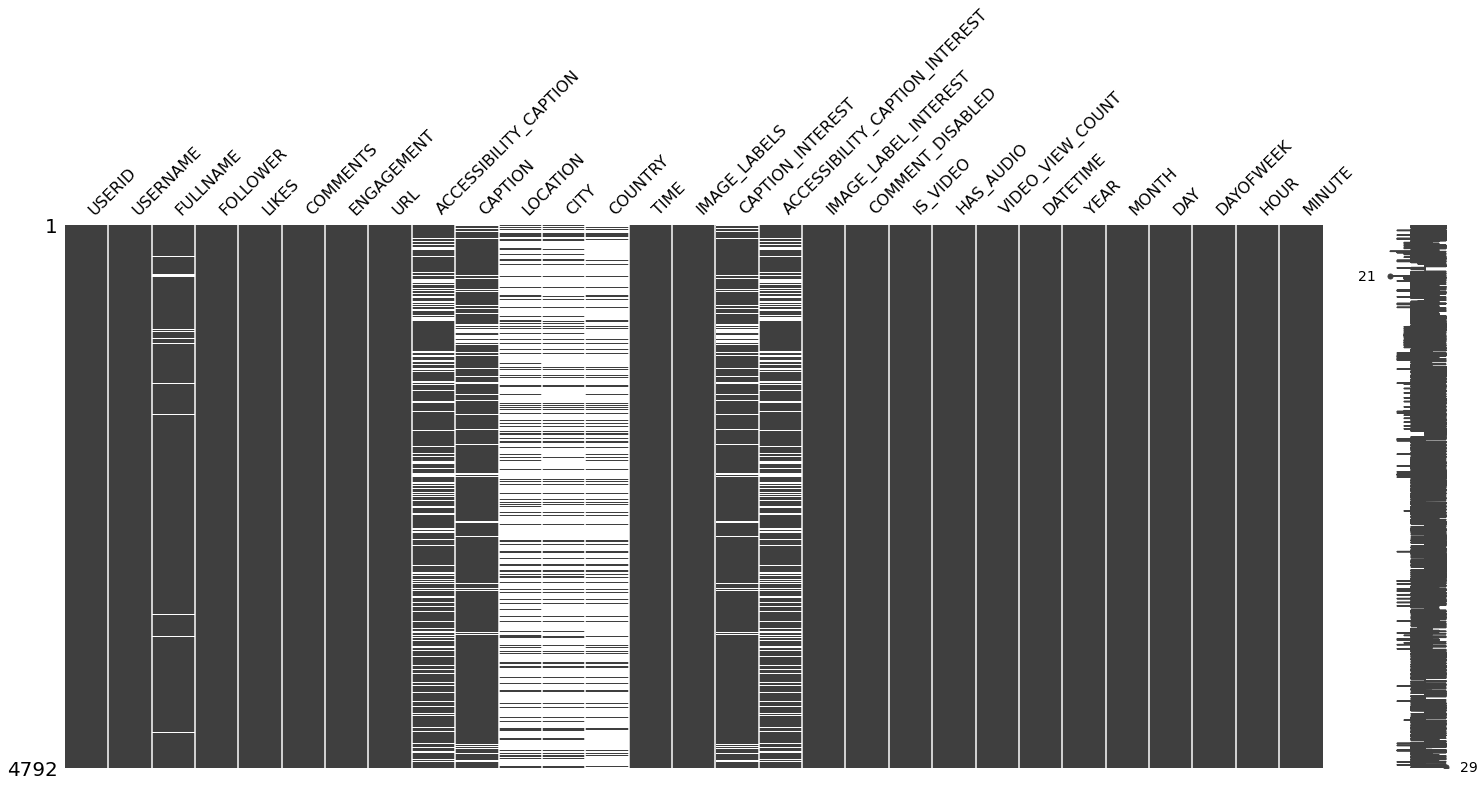

In [109]:
msno.matrix(df)

In [110]:
#https://datatofish.com/rows-with-nan-pandas-dataframe/
#len(df[df['FULLNAME'].isna()]) # 126 #849
#df[df['FULLNAME'].isnull()]
#df[df.isna().any(axis=1)] # len = 4020
# df[df.isnull().any(axis=1)]

In [111]:
for col in df.columns:
    if len(df[df[col].isnull()]) > 0:
      df[col] = df[col].fillna('Null')
      print(col)

FULLNAME
ACCESSIBILITY_CAPTION
CAPTION
LOCATION
CITY
COUNTRY
IMAGE_LABELS
CAPTION_INTEREST
ACCESSIBILITY_CAPTION_INTEREST
IMAGE_LABEL_INTEREST


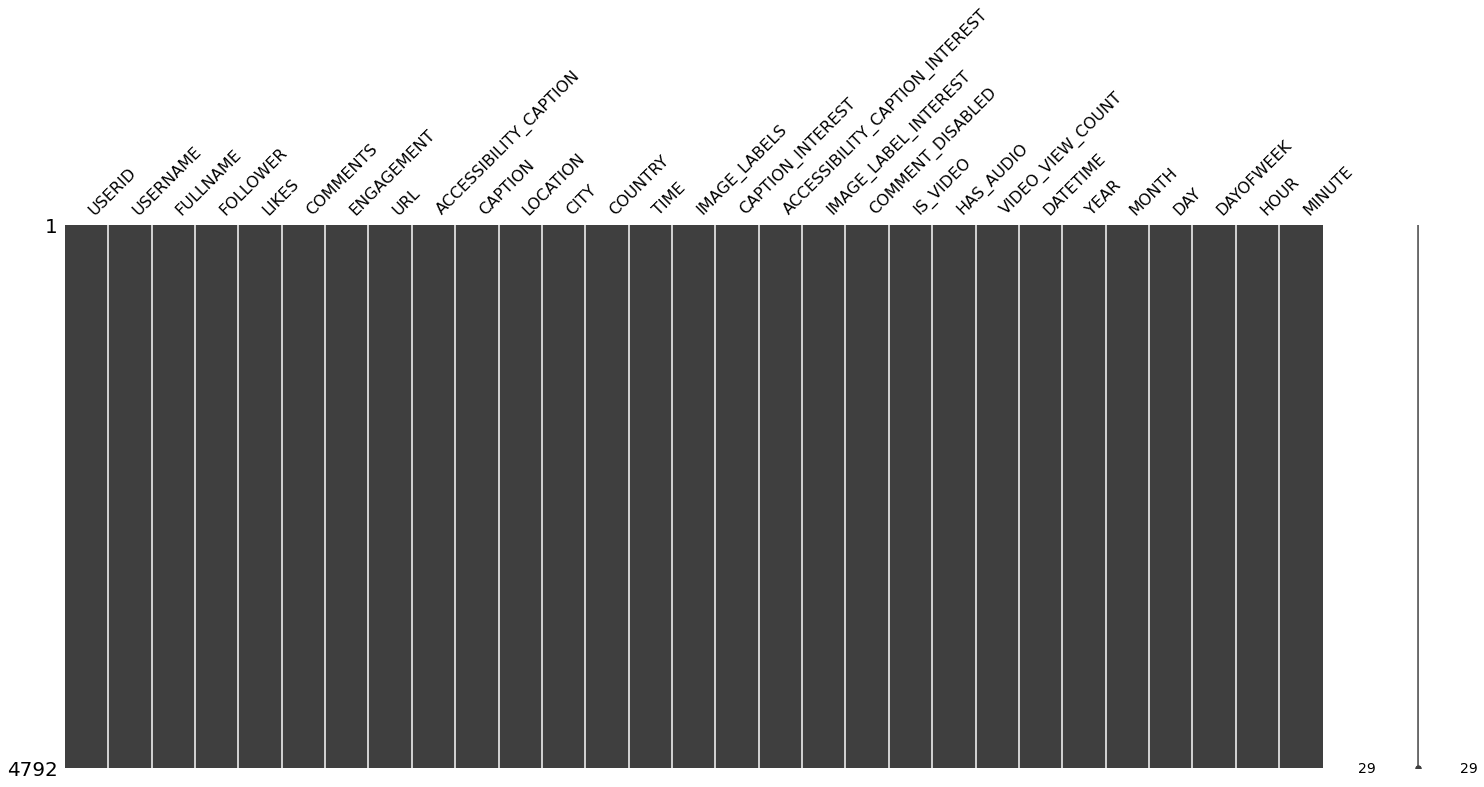

In [112]:
msno.matrix(df)

## Replacing Charecters  with Number uning OrdinalEncoder

In [113]:
# list of char / object columns

In [114]:
df.dtypes

USERID                                     int64
USERNAME                                  object
FULLNAME                                  object
FOLLOWER                                   int64
LIKES                                      int64
COMMENTS                                   int64
ENGAGEMENT                               float64
URL                                       object
ACCESSIBILITY_CAPTION                     object
CAPTION                                   object
LOCATION                                  object
CITY                                      object
COUNTRY                                   object
TIME                                       int64
IMAGE_LABELS                              object
CAPTION_INTEREST                          object
ACCESSIBILITY_CAPTION_INTEREST            object
IMAGE_LABEL_INTEREST                      object
COMMENT_DISABLED                           int64
IS_VIDEO                                   int64
HAS_AUDIO           

In [115]:
df.select_dtypes(include=['object']).dtypes

USERNAME                          object
FULLNAME                          object
URL                               object
ACCESSIBILITY_CAPTION             object
CAPTION                           object
LOCATION                          object
CITY                              object
COUNTRY                           object
IMAGE_LABELS                      object
CAPTION_INTEREST                  object
ACCESSIBILITY_CAPTION_INTEREST    object
IMAGE_LABEL_INTEREST              object
dtype: object

In [116]:
df.select_dtypes(include=['object']).dtypes.index

Index(['USERNAME', 'FULLNAME', 'URL', 'ACCESSIBILITY_CAPTION', 'CAPTION',
       'LOCATION', 'CITY', 'COUNTRY', 'IMAGE_LABELS', 'CAPTION_INTEREST',
       'ACCESSIBILITY_CAPTION_INTEREST', 'IMAGE_LABEL_INTEREST'],
      dtype='object')

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4792 entries, 1918 to 6709
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   USERID                          4792 non-null   int64         
 1   USERNAME                        4792 non-null   object        
 2   FULLNAME                        4792 non-null   object        
 3   FOLLOWER                        4792 non-null   int64         
 4   LIKES                           4792 non-null   int64         
 5   COMMENTS                        4792 non-null   int64         
 6   ENGAGEMENT                      4792 non-null   float64       
 7   URL                             4792 non-null   object        
 8   ACCESSIBILITY_CAPTION           4792 non-null   object        
 9   CAPTION                         4792 non-null   object        
 10  LOCATION                        4792 non-null   object        
 11  C

In [118]:
enc = OrdinalEncoder()

Many columns:

In [119]:
for col in df.select_dtypes(include=['object']).dtypes.index:
#for col in ['USERNAME','FULLNAME']:
  #col_list = pd.DataFrame(df[col].unique())
  #col_list.rename(columns = {0:col},inplace=True)
  #col_list.rename(columns = {0:col},inplace=True)
  enc.fit(df[[col]])
  df[col + '_OBJECT_AS_INT'] = enc.transform(df[[col]])
  #print(col)

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4792 entries, 1918 to 6709
Data columns (total 41 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   USERID                                        4792 non-null   int64         
 1   USERNAME                                      4792 non-null   object        
 2   FULLNAME                                      4792 non-null   object        
 3   FOLLOWER                                      4792 non-null   int64         
 4   LIKES                                         4792 non-null   int64         
 5   COMMENTS                                      4792 non-null   int64         
 6   ENGAGEMENT                                    4792 non-null   float64       
 7   URL                                           4792 non-null   object        
 8   ACCESSIBILITY_CAPTION                         4792 non-null   obj

In [121]:
df.head(2)

,USERID,USERNAME,FULLNAME,FOLLOWER,LIKES,COMMENTS,ENGAGEMENT,URL,ACCESSIBILITY_CAPTION,CAPTION,LOCATION,CITY,COUNTRY,TIME,IMAGE_LABELS,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST,IMAGE_LABEL_INTEREST,COMMENT_DISABLED,IS_VIDEO,HAS_AUDIO,VIDEO_VIEW_COUNT,DATETIME,YEAR,MONTH,DAY,DAYOFWEEK,HOUR,MINUTE,USERNAME_OBJECT_AS_INT,FULLNAME_OBJECT_AS_INT,URL_OBJECT_AS_INT,ACCESSIBILITY_CAPTION_OBJECT_AS_INT,CAPTION_OBJECT_AS_INT,LOCATION_OBJECT_AS_INT,CITY_OBJECT_AS_INT,COUNTRY_OBJECT_AS_INT,IMAGE_LABELS_OBJECT_AS_INT,CAPTION_INTEREST_OBJECT_AS_INT,ACCESSIBILITY_CAPTION_INTEREST_OBJECT_AS_INT,IMAGE_LABEL_INTEREST_OBJECT_AS_INT
LINE_NUM_INDEX,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1918,36193140327,elastici_e_passamaneria,Elastici e Passamaneria,1052,23,0,2.19,https://www.instagram.com/p/CMegChUlwm2,"Photo by Elastici e Passamaneria on March 16, 2021.",FFP2 MADE IN ITALY????????#ffp2mask#italianstyle#madeinitaly????????#produzionepropria#produttori#farmacie#farmacieitaliane#parafarmacia#mascherinelavabili#mask#ffp2,Null,Null,Null,1615891163,"Clothing, Apparel, Text, Money, Collage, Advertisement, Poster",education,movies,business,0,0,0,0.0,2021-03-16 10:39:23,2021,3,16,1,10,39,107.0,122.0,1124.0,821.0,1336.0,318.0,213.0,28.0,1128.0,12.0,15.0,5.0
1919,8210198494,pamela.latorre.73,Pamela La Torre,309,55,23,25.24,https://www.instagram.com/p/CQETjgBnZ7s,"Photo by Pamela La Torre on June 13, 2021. May be an image of one or more people, people standing and indoor.",Prima comunione Giorgio,Santissimo Crocifisso,"Taranto, Italy",Null,1623602137,"Person, Human, Photographer, Photography, Photo, Furniture, Shoe, Clothing, Footwear, Apparel, Interior Design, Indoors",news,arts_entertainment,style_fashion,0,0,0,0.0,2021-06-13 16:35:37,2021,6,13,6,16,35,309.0,275.0,3586.0,1915.0,2828.0,393.0,296.0,28.0,3407.0,26.0,2.0,31.0


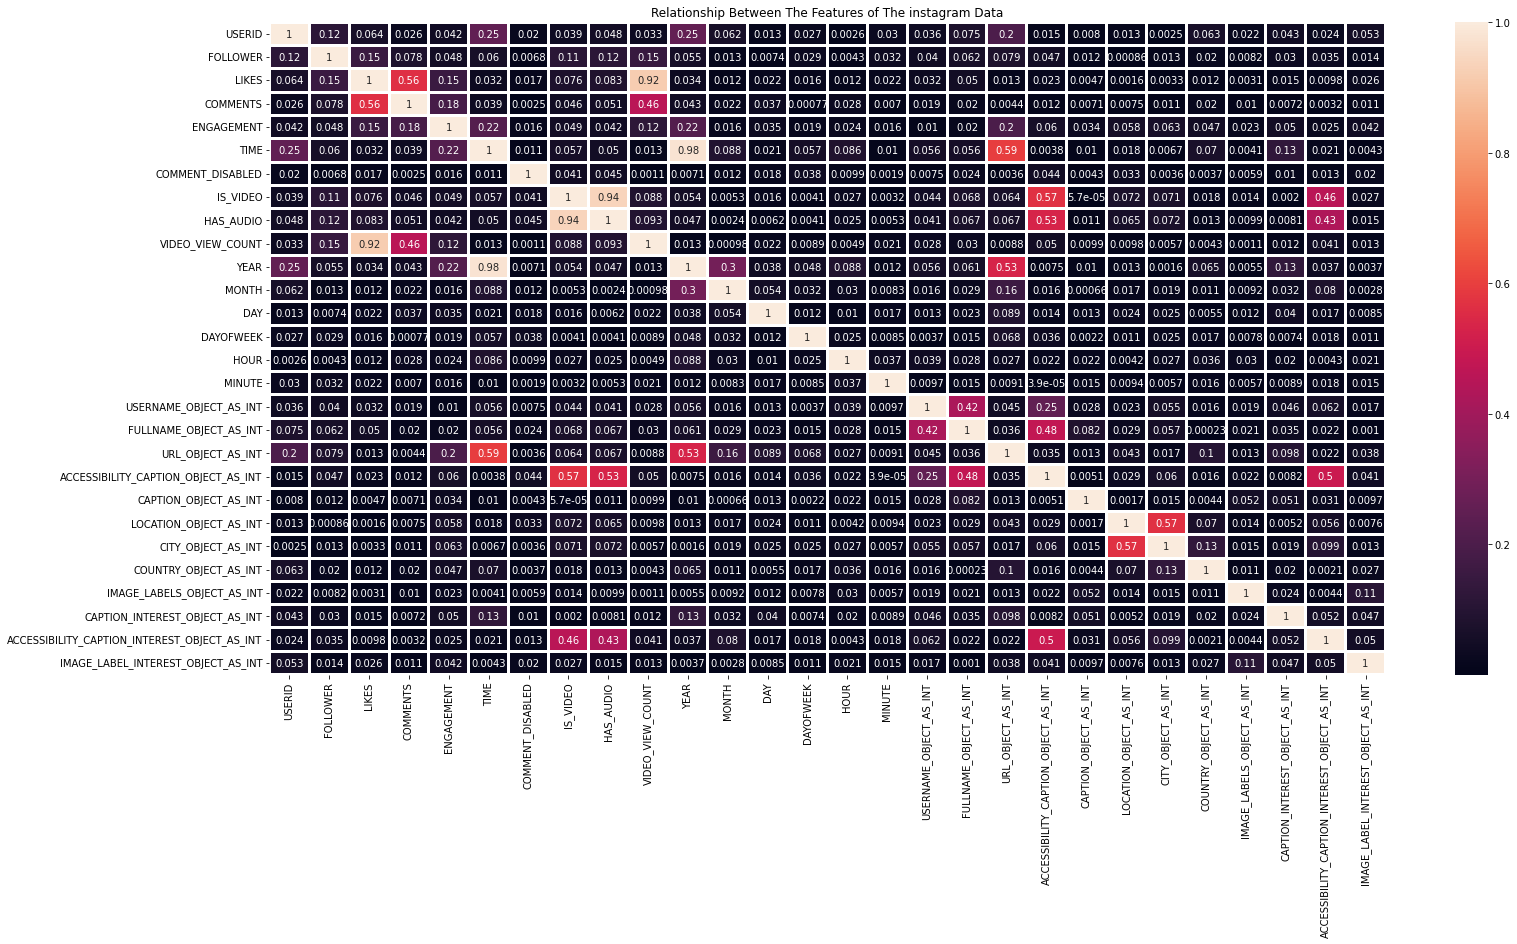

In [127]:
plt.figure(figsize=(25,12))
plt.title("Relationship Between The Features of The instagram Data")
sns.heatmap(df.corr().abs(), annot=True, linewidths = 2, linecolor = "white")

## Feature Engneering

Eladk 2021-Sep-17, we need to:


*   convert y colum to 5 classes so we can have a classification problem and not a regresion model
*   check if the data is inbalance (so we need to use stratify)



# Split the Data

select only int and float column types to X 
seletc LIKES, COMMENTS, ENGAGEMENT as y

In [123]:
df.columns

Index(['USERID', 'USERNAME', 'FULLNAME', 'FOLLOWER', 'LIKES', 'COMMENTS',
       'ENGAGEMENT', 'URL', 'ACCESSIBILITY_CAPTION', 'CAPTION', 'LOCATION',
       'CITY', 'COUNTRY', 'TIME', 'IMAGE_LABELS', 'CAPTION_INTEREST',
       'ACCESSIBILITY_CAPTION_INTEREST', 'IMAGE_LABEL_INTEREST',
       'COMMENT_DISABLED', 'IS_VIDEO', 'HAS_AUDIO', 'VIDEO_VIEW_COUNT',
       'DATETIME', 'YEAR', 'MONTH', 'DAY', 'DAYOFWEEK', 'HOUR', 'MINUTE',
       'USERNAME_OBJECT_AS_INT', 'FULLNAME_OBJECT_AS_INT', 'URL_OBJECT_AS_INT',
       'ACCESSIBILITY_CAPTION_OBJECT_AS_INT', 'CAPTION_OBJECT_AS_INT',
       'LOCATION_OBJECT_AS_INT', 'CITY_OBJECT_AS_INT', 'COUNTRY_OBJECT_AS_INT',
       'IMAGE_LABELS_OBJECT_AS_INT', 'CAPTION_INTEREST_OBJECT_AS_INT',
       'ACCESSIBILITY_CAPTION_INTEREST_OBJECT_AS_INT',
       'IMAGE_LABEL_INTEREST_OBJECT_AS_INT'],
      dtype='object')

In [124]:
X = df.select_dtypes(include=['number'])
X.drop(['LIKES','COMMENTS','ENGAGEMENT'], axis=1, inplace=True) #['LIKES','COMMENTS','ENGAGEMENT']

In [125]:
y = df['ENGAGEMENT']
y1 = df['LIKES']
y2 = df['COMMENTS']

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = train_size\
                           , random_state = rand_state) #, stratify=unique_data_int.RainTomorrow)

# Mechine Learning  Model

## Appling First1 Model 

## Validating the Model 

## Scoring 